# 使用扩展卡尔曼滤波求解手机的姿态
介绍使用扩展卡尔曼滤波来求解手机的姿态。

先加载采集的数据进行分析。

In [1]:
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
from JayQuaternion import *
%matplotlib inline

In [2]:
import pandas as pd
# 读取采集的数据文件
acc_data = pd.read_csv("acc.txt", sep=" ", names=['timestamp', 'x', 'y', 'z']) # 加速计
gyr_data = pd.read_csv("gyr.txt", sep=" ", names=['timestamp', 'x', 'y', 'z']) # 陀螺仪
mag_data = pd.read_csv("mag.txt", sep=" ", names=['timestamp', 'x', 'y', 'z']) # 磁力计
ori_data = pd.read_csv("ori.txt", sep=" ", names=['timestamp', 'w', 'x', 'y', 'z']) # iOS提供的姿态参考值

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10847b750>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1085394d0>], dtype=object)

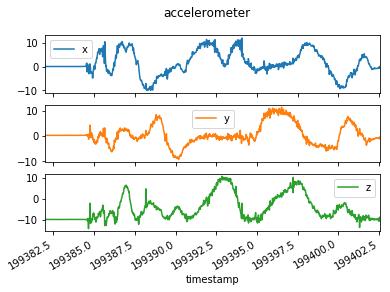

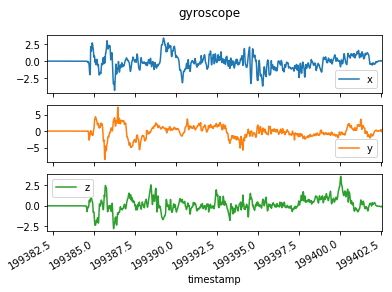

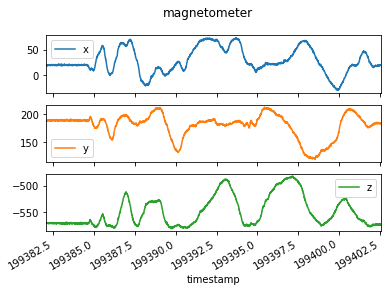

In [3]:
# 绘制出采集的数据
acc_data.plot(x="timestamp", subplots=True, title=u"accelerometer")
gyr_data.plot(x="timestamp", subplots=True, title=u"gyroscope")
mag_data.plot(x="timestamp", subplots=True, title=u"magnetometer")

绘制出iOS系统提供的设备姿态四元数变化情况

In [4]:
# iOS提供的姿态四元数
a_array = []
for q in ori_data.as_matrix()[:, 1:]:
    a_array.append(Quaternion(q))
animation_quanternions(a_array)

数据采集说明：最初将手机置于水平面（大于200帧），然后旋转手机，尽量减少线性运动。
由于存在噪声，统计位于水平面上时的前面一段时间的数据，来去除bias及确定噪声协方差。

## 获取先验信息
下面先统计磁力计数据。

timestamp           x           y           z
count     200.000000  200.000000  200.000000  200.000000
mean   199383.016884   19.769330  189.171519 -570.380876
std         0.567070    0.730716    0.794686    0.746966
min    199382.041989   17.814178  187.136993 -572.633545
25%    199382.529486   19.225204  188.548019 -570.951843
50%    199383.016999   19.754333  189.165352 -570.279114
75%    199383.504279   20.283478  189.782669 -569.942749
max    199383.991827   22.047256  191.546448 -567.924683

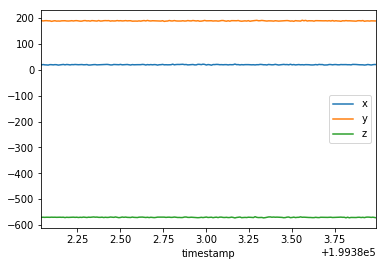

In [5]:
mag_data[:200].plot(x="timestamp")
mag_data[:200].describe()

磁力计均值为`[19.769330, 189.171519, -570.380876]`， 
方差为`[0.730716, 0.794686, 0.746966]`

由于处于水平面，可以使用均值来初始化世界坐标帧下的加速计向量：
$$m^W = \begin{pmatrix}0 & \sqrt{m_x^2 + m_y^2} & m_z\end{pmatrix}$$

In [6]:
m_w = np.array([0, np.sqrt(19.76933**2 + 189.171519**2), -570.380876])
e_m = np.array([0.730716, 0.794686, 0.746966]) # 磁力计噪声19.769330

下面统计加速计信息

timestamp           x           y           z
count     200.000000  200.000000  200.000000  200.000000
mean   199382.989360    0.021103    0.206204   -9.842947
std         0.579764    0.009110    0.009122    0.009228
min    199381.992708   -0.005089    0.179327   -9.862541
25%    199382.491028    0.013921    0.200059   -9.850566
50%    199382.989346    0.020582    0.206346   -9.843605
75%    199383.487697    0.027618    0.211997   -9.835671
max    199383.986031    0.044757    0.231868   -9.820478

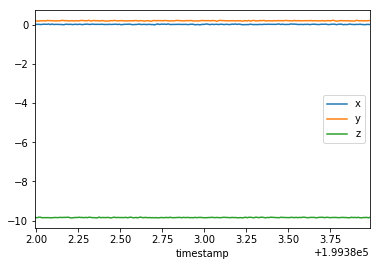

In [7]:
acc_data[:200].plot(x="timestamp")
acc_data[:200].describe()

静止80帧，加速计的方差为`[0.009110, 0.009122, 0.009228]`，可作为加速计过程噪声.

世界坐标系下的归一化的重力加速度为$$g^W = \left(0, 0, -1\right)$$

In [8]:
g_w = np.array([0, 0, -1])
e_a = np.array([0.009110, 0.009122, 0.009228])

统计陀螺仪信息

timestamp           x           y           z
count     200.000000  200.000000  200.000000  200.000000
mean   199383.113252   -0.021426    0.032169   -0.015871
std         0.578330    0.001007    0.001056    0.000773
min    199382.119049   -0.024582    0.029686   -0.018218
25%    199382.616151   -0.022448    0.031809   -0.016094
50%    199383.113248   -0.021385    0.031817   -0.016087
75%    199383.610359   -0.020320    0.032876   -0.015027
max    199384.107459   -0.019248    0.036071   -0.013952

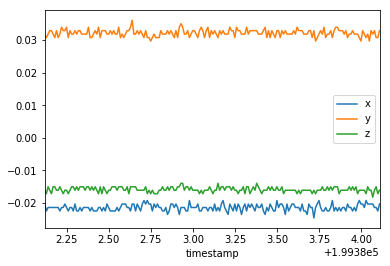

In [9]:
gyr_data[:200].plot(x="timestamp")
gyr_data[:200].describe()

静止状态下的平均值为`[-0.021426, 0.032169, -0.015871]`，可作为陀螺仪的bias，过程噪声为方差`[0.001007, 0.001056, 0.000773]`

In [10]:
w_b = np.array([-0.023339, 0.031220, -0.015685]) # 以均值作为陀螺仪bias
e_w = np.array([0.001007, 0.001056, 0.000773])   # 以方差作为陀螺仪过程噪声

先验位姿通过以下模型进行计算。
$$
\begin{eqnarray}
g^W &= & \begin{pmatrix} 0 & 0 & -1\end{pmatrix} ^T, \quad \quad & g^S &= \frac{y_{a,1}} {\left\|y_{a,1}\right\|_2} \\
m^W &= & \begin{pmatrix} 0 & 1 & 0\end{pmatrix}^T, \quad \quad & m^S &= g^S \times ( \frac{y_{m,1}} {\left\|y_{m,1}\right\|_2} \times g^S )
\end{eqnarray}
$$
$$
\max_{q^{W/S}} \left\| \overline{g}^W - q^{W/S}\odot \overline g^S\odot q^{S/W} \right\|_2^2+ \left\| \overline m ^W - q^{W/S}\odot \overline m ^ S \odot q^{S/W} \right\|_2^2 \\
s.t.\quad \left\|q^{W/S} \right\|_2 = 1
$$



In [11]:
# 先计算先验姿态四元数
def prior():
    g_w_p = np.array([0, 0, -1])
    m_w_p = np.array([0, 1, 0])
    a_s = acc_data.as_matrix()[0][1:]
    m_s = mag_data.as_matrix()[0][1:]
    a_s = a_s / np.linalg.norm(a_s)
    m_s = m_s / np.linalg.norm(m_s)
    m_s = np.cross(a_s, np.cross(m_s, a_s))
    A = - np.dot(functionL(overline(g_w_p)), functionR(overline(a_s))) - np.dot(functionL(overline(m_w_p)), functionR(overline(m_s)))
    w, v = np.linalg.eig(A)
    q0 = v[:, w.argmax()]
    P3 = 0.35**2 * np.eye(3) # 20/180*pi = 0.35，覆盖20°的误差
    I43 = np.zeros((4,3))
    I43[1:, :] = np.eye(3)
    I34 = np.transpose(I43)
    P = 0.25 * np.dot(np.dot(functionL(q0), I43), np.dot(P3, np.dot(I34, functionL(inverse_q(q0)))))
    return q0, P

q, P = prior()
q = norm_q(q)

绘制先验四元数

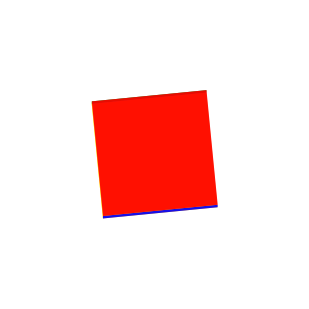

In [12]:
plotQuaternion(Quaternion(q))

**可以看出先验四元数与iOS提供的初始姿态四元数相近。**

时间更新
$$
\begin{align*}
q_{t+1} &= \left(I +\frac{\Delta t}2S(y_{w,t})\right)q_t + \frac {\Delta t}2\overline S(q_t) \omega_t \\
& = F_t q_t + G_t\omega_t \\
P_{t+1} &=  F_tP_tF_t^T + G_tQG_t^T
\end{align*}
$$

In [13]:
def time_update(q, P, delta_t, w, omega_w):
    u"""时间更新"""
    F = np.eye(4) + 0.5 * delta_t *S(w - w_b) # 去除bias
    G = 0.5 * delta_t * hatS(q)
    q = np.dot(F, q)
    Q = np.array([[omega_w[0]**2, 0, 0], [0, omega_w[1]**2, 0], [0, 0, omega_w[2]]])
    Q = Q**2
    P = np.dot(np.dot(F, P), np.transpose(F)) + np.dot(np.dot(G, Q), np.transpose(G))
    return q, P

假定加速计只测量重力加速度，所有测量更新方程如下：
$$
\begin{align*}
y_{a, t} &= Q^T(q_t)g^W + e_t^a \\
& = h_t(q_t) + e_t^a \\
H_t &= \frac{\partial h_t(q_t)}{\partial q_t} = \left(\frac{\partial Q(q_t)}{\partial q_t}\right)^T\\
S_t &= H_tP_tH_t^T + R \\
K_t &= P_tH_t^TS_t^{-1} \\
\varepsilon_t & = y_{a,t}-Q^T(q_T)g^W \\
\hat q_t &= q_t + \varepsilon\_t \\
\hat P_t &= P_t - K_tS_tK_t^T
\end{align*}
$$


In [14]:
def acc_measure_update(q, P, y_a, omega_a, g_w):
    Q0,Q1,Q2,Q3 = dQqdq(q)
    derQ = np.transpose(np.array([np.dot(np.transpose(Q0), g_w),
                     np.dot(np.transpose(Q1), g_w),
                     np.dot(np.transpose(Q2), g_w),
                     np.dot(np.transpose(Q3), g_w)]))
    Q = Qq(q)
    h = np.dot(np.transpose(Q), g_w)
    R = np.array([[omega_a[0], 0, 0], [0, omega_a[1], 0], [0, 0, omega_a[2]]])
    R = R**2
    S = np.dot(np.dot(derQ, P), np.transpose(derQ)) + R
    K = np.dot(np.dot(P, np.transpose(derQ)), np.linalg.inv(S))
    y_a = y_a / np.linalg.norm(y_a) # 归一化
    q = q + np.dot(K, (y_a - h))
    P = P - np.dot(np.dot(K, S), np.transpose(K))
    return q, P

def mag_measure_update(q, P, y_m, omega_m, m_w):
    Q0,Q1,Q2,Q3 = dQqdq(q)
    derQ = np.transpose(np.array([np.dot(np.transpose(Q0), m_w),
                     np.dot(np.transpose(Q1), m_w),
                     np.dot(np.transpose(Q2), m_w),
                     np.dot(np.transpose(Q3), m_w)]))
    Q = Qq(q)
    h = np.dot(np.transpose(Q), m_w)
    R = np.array([[omega_m[0], 0, 0], [0, omega_m[1], 0], [0, 0, omega_m[2]]])
    R = R**2
    S = np.dot(np.dot(derQ, P), np.transpose(derQ)) + R
    K = np.dot(np.dot(P, np.transpose(derQ)), np.linalg.inv(S))
    # y_m = y_m / np.linalg.norm(y_m)
    q = q + np.dot(K, (y_m - h))
    P = P - np.dot(np.dot(K, S), np.transpose(K))
    return q, P


In [15]:
# 执行一次时间更新，一次加速计测量更新和一次磁力计测量更新
q_result = [Quaternion(q)]
for i in range(1, len(gyr_data)):
    # time update
    q, P = time_update(q, P, gyr_data.as_matrix()[i][0] - gyr_data.as_matrix()[i-1][0], gyr_data.as_matrix()[i][1:], e_w)
    q = norm_q(q)
    
    # acc measure update
    q, P = acc_measure_update(q, P, acc_data.as_matrix()[i][1:], e_a, g_w)
    q = norm_q(q)
    
    # mag measure update
    q, P = mag_measure_update(q, P, mag_data.as_matrix()[i][1:], e_m, m_w)
    q = norm_q(q)
    q_result.append(Quaternion(q))

In [16]:
animation_quanternions(q_result)

可以看出，前面一段静止时间，系统扰动较大，与iOS系统提供的四元数相差较大。

In [17]:
# 只执行一次时间更新
q, P = prior()
q = norm_q(q)

q_result = [Quaternion(q)]
for i in range(1, len(gyr_data)):
    # time update
    q, P = time_update(q, P, gyr_data.as_matrix()[i][0] - gyr_data.as_matrix()[i-1][0], gyr_data.as_matrix()[i][1:], e_w)
    q = norm_q(q)
    q_result.append(Quaternion(q))

animation_quanternions(q_result)

In [18]:
# 执行一次时间更新和一次加速计测量更新
q, P = prior()
q = norm_q(q)

q_result = [Quaternion(q)]
for i in range(1, len(gyr_data)):
    # time update
    q, P = time_update(q, P, gyr_data.as_matrix()[i][0] - gyr_data.as_matrix()[i-1][0], gyr_data.as_matrix()[i][1:], e_w)
    q = norm_q(q)
    
    # acc measure update
    q, P = acc_measure_update(q, P, acc_data.as_matrix()[i][1:], e_a, g_w)
    q = norm_q(q)
    
    q_result.append(Quaternion(q))

animation_quanternions(q_result)

In [19]:
# 执行一次时间更新和一次磁力计测量更新
q, P = prior()
q = norm_q(q)

q_result = [Quaternion(q)]
for i in range(1, len(gyr_data)):
    # time update
    q, P = time_update(q, P, gyr_data.as_matrix()[i][0] - gyr_data.as_matrix()[i-1][0], gyr_data.as_matrix()[i][1:], e_w)
    q = norm_q(q)
    
    # mag measure update
    q, P = mag_measure_update(q, P, mag_data.as_matrix()[i][1:], e_m, m_w)
    q = norm_q(q)
    q_result.append(Quaternion(q))

animation_quanternions(q_result)

通过上述对比，只执行时间更新函数提供的四元数较为稳定，与iOS系统提供的四元数相近。

执行时间更新函数和加速计测量更新函数，会由扰动，主要原因在于加速计没有进行标定，存在零偏的干扰。

类似的执行时间更新和磁力计测量更新，会产生更加大的误差，这可以从原本应该静止的前200帧看出，系统给出的四元数扰动十分剧烈。

执行一次时间更新、一次加速计测量更新和一次磁力计测量更新，系统抖动更加严重。究其原因，一方面是传感器需要进行标定去除零偏的影响；另一方面，先验条件并不满足，设置的先验协方差存在很大的偏差，导致系统的测量更新方程对系统的影响更大，使得系统表现较差。